In [2]:
import pandas as pd
import numpy as np
from src import config
from src.config import RAW_DATA_PATH, PROCESSED_DATA_PATH
import seaborn as sns
import matplotlib.pyplot as plt
#df = pd.read_csv(RAW_DATA_PATH / "Sports_and_Outdoors.csv")


In [39]:
# Umwandlung der unixReviewTime in ein lesbares Datumsobjekt
df['date'] = pd.to_datetime(df['timestamp'], unit='ms')
df.drop(columns=['timestamp', 'year_month'], inplace=True)
print(df['date'].min(), df['date'].max())  # sanity check by printing earliest and latest entry (should be 2000 and 2023)
print(df.head())

2000-05-01 19:11:41 2023-09-14 05:40:41.162000
                        user_id parent_asin  rating                    date
0  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B00NXQLFQQ     5.0 2018-04-07 09:36:11.676
1  AFKZENTNBQ7A7V7UXW5JJI6UGRYQ  B0BGFR76CF     5.0 2023-02-25 10:30:53.520
2  AGGZ357AO26RQZVRLGU4D4N52DZQ  B001D08ZBW     4.0 2012-03-14 02:28:37.000
3  AGGZ357AO26RQZVRLGU4D4N52DZQ  B00GAG0LDO     4.0 2015-07-31 01:08:40.000
4  AGGZ357AO26RQZVRLGU4D4N52DZQ  B07NJ2SZQX     5.0 2019-11-08 18:25:36.081


C:\Users\U762387\AppData\Local\Temp\ipykernel_15332\3740755516.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='rating', data=df, palette='viridis')
C:\Users\U762387\AppData\Local\Temp\ipykernel_15332\3740755516.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_data = time_data.set_index('date').resample('M').sum().reset_index()


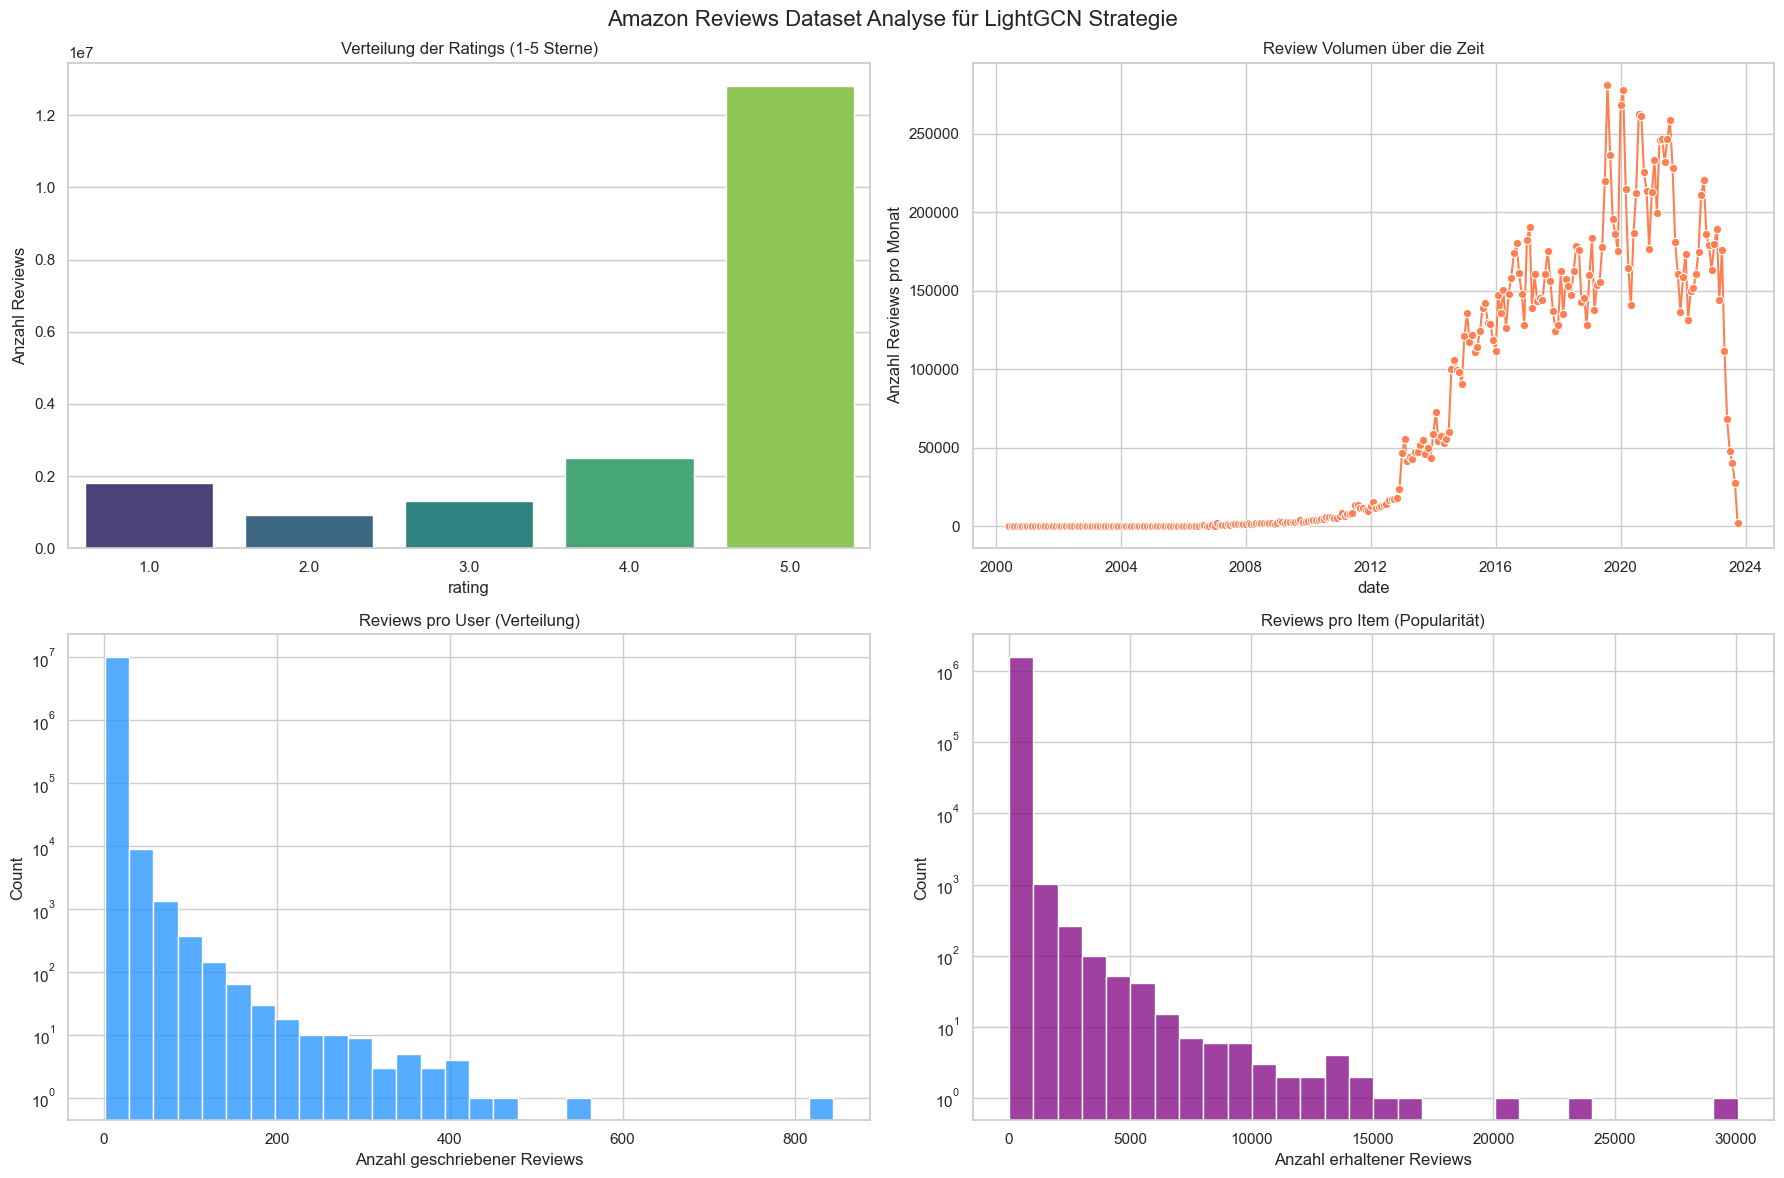

In [43]:

# Setzen des Styles für schönere Plots
sns.set_theme(style="whitegrid")

# Erstellen einer Figure mit Subplots für Übersichtlichkeit
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Amazon Reviews Dataset Analyse für LightGCN Strategie', fontsize=16)
# ---------------------------------------------------------
# PLOT A: Rating Verteilung
# Wichtig für: Müssen wir negative Samples filtern?
# ---------------------------------------------------------
sns.countplot(ax=axes[0, 0], x='rating', data=df, palette='viridis')
axes[0, 0].set_title('Verteilung der Ratings (1-5 Sterne)')
axes[0, 0].set_ylabel('Anzahl Reviews')

# ---------------------------------------------------------
# PLOT B: Zeitliche Verteilung (Review Volume over Time)
# Wichtig für: Entscheidung zwischen Random vs. Temporal Split
# ---------------------------------------------------------
# Wir gruppieren nach Datum, um das Volumen pro Zeit zu sehen
time_data = df.groupby('date').size().reset_index(name='counts')
# Resampling auf Monate für glattere Kurven (bei großen Datenmengen wichtig)
time_data = time_data.set_index('date').resample('M').sum().reset_index()

sns.lineplot(ax=axes[0, 1], x='date', y='counts', data=time_data, marker='o', color='coral')
axes[0, 1].set_title('Review Volumen über die Zeit')
axes[0, 1].set_ylabel('Anzahl Reviews pro Monat')

# ---------------------------------------------------------
# PLOT C: User Interaktionen (Sparsity Check)
# Wichtig für: Filtern von inaktiven Usern (k-core filtering)
# ---------------------------------------------------------
# Da wir hier nur Dummy-Daten haben, simulieren wir für die Erklärung:
user_counts = df['user_id'].value_counts()

# Histogramm der User-Interaktionen (log scale ist hier oft nötig bei echten Daten)
sns.histplot(ax=axes[1, 0], x=user_counts, bins=30, kde=False, color='dodgerblue')
axes[1, 0].set_title('Reviews pro User (Verteilung)')
axes[1, 0].set_xlabel('Anzahl geschriebener Reviews')
axes[1, 0].set_yscale('log') # Log-Skala, da Amazon Daten "Long Tail" sind

# ---------------------------------------------------------
# PLOT D: Item Popularität
# Wichtig für: Wie stark bias das Modell zu populären Items tendieren wird
# ---------------------------------------------------------
item_counts = df['parent_asin'].value_counts()

sns.histplot(ax=axes[1, 1], x=item_counts, bins=30, kde=False, color='purple')
axes[1, 1].set_title('Reviews pro Item (Popularität)')
axes[1, 1].set_xlabel('Anzahl erhaltener Reviews')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

In [44]:
print("total users:", df['user_id'].nunique())
print("total items:", df['parent_asin'].nunique())

total users: 10331141
total items: 1587219


In [7]:
df_train = pd.read_csv(PROCESSED_DATA_PATH / "sports_and_outdoors_global_temporal_split/train.csv", names=['user_id', 'parent_asin', 'rating', 'timestamp'])
#df_val = pd.read_csv(PROCESSED_DATA_PATH / "sports_and_outdoors_global_temporal_split/valid.csv", names=['user_id', 'parent_asin', 'rating', 'timestamp'])
df_test = pd.read_csv(PROCESSED_DATA_PATH / "sports_and_outdoors_global_temporal_split/test.csv", names=['user_id', 'parent_asin', 'rating', 'timestamp'])


In [8]:
print("Train users:", df_train['user_id'].nunique())
#print("Val users:", df_val['user_id'].nunique())
print("Test users:", df_test['user_id'].nunique())
print("Total interactions:", len(df_train) + len(df_test))
print("Train interactions:", len(df_train))
#print("Val interactions:", len(df_val))
print("Test interactions:", len(df_test))
print("Train percentage:", len(df_train) / (len(df_train) + len(df_test)))
#print("Val percentage:", len(df_val) / (len(df_train) + len(df_val) + len(df_test)))
print("Test percentage:", len(df_test) / (len(df_train) + len(df_test)))

Train users: 396764
Test users: 121364
Total interactions: 3239495
Train interactions: 2977785
Test interactions: 261710
Train percentage: 0.9192127167969082
Test percentage: 0.08078728320309184


In [9]:
df_train['date'] = pd.to_datetime(df_train['timestamp'], unit='ms')
print(f"Trainingsdaten von " , df_train['date'].min(), "bis", df_train['date'].max())
#df_val['date'] = pd.to_datetime(df_val['timestamp'], unit='ms')
#print(f"Validierungsdaten von " , df_val['date'].min(), "bis", df_val['date'].max())
df_test['date'] = pd.to_datetime(df_test['timestamp'], unit='ms')
print(f"Testdaten von " , df_test['date'].min(), "bis", df_test['date'].max())

Trainingsdaten von  2000-10-02 20:53:10 bis 2021-12-31 22:59:57.932000
Testdaten von  2021-12-31 23:02:20.659000 bis 2023-09-07 17:38:07.255000


In [4]:
import pandas as pd
from src.config import RAW_DATA_PATH
df_original_data = pd.read_csv(RAW_DATA_PATH / "Sports_and_Outdoors.csv")
print("Average ratings per user in original data:", len(df_original_data) / df_original_data['user_id'].nunique())
print("Total users in original data:", df_original_data['user_id'].nunique())
print("Total items in original data:", df_original_data['parent_asin'].nunique())
print("Total interactions in original data:", len(df_original_data))

Average ratings per user in original data: 1.8729202321408642
Total users in original data: 10331141
Total items in original data: 1587219
Total interactions in original data: 19349403


# Movielens 32m


In [55]:
df_movie = pd.read_csv(RAW_DATA_PATH / "movielens-32m/ratings.csv")
print("total users:", df_movie['userId'].nunique())
print("total items:", df_movie['movieId'].nunique())
print("total ratings:", len(df_movie))
df_movie.head()

total users: 200948
total items: 84432
total ratings: 32000204


,userId,movieId,rating,timestamp
0,1,17,4.0,944249077
1,1,25,1.0,944250228
2,1,29,2.0,943230976
3,1,30,5.0,944249077
4,1,32,5.0,943228858


In [56]:
df_movie['date'] = pd.to_datetime(df_movie['timestamp'], unit='s')
print(df_movie['date'].min(), df_movie['date'].max())

1995-01-09 11:46:44 2023-10-13 02:29:07


C:\Users\U762387\AppData\Local\Temp\ipykernel_15332\1339964747.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(ax=axes[0, 0], x='rating', data=df, palette='viridis')
C:\Users\U762387\AppData\Local\Temp\ipykernel_15332\1339964747.py:22: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  time_data = time_data.set_index('date').resample('M').sum().reset_index()


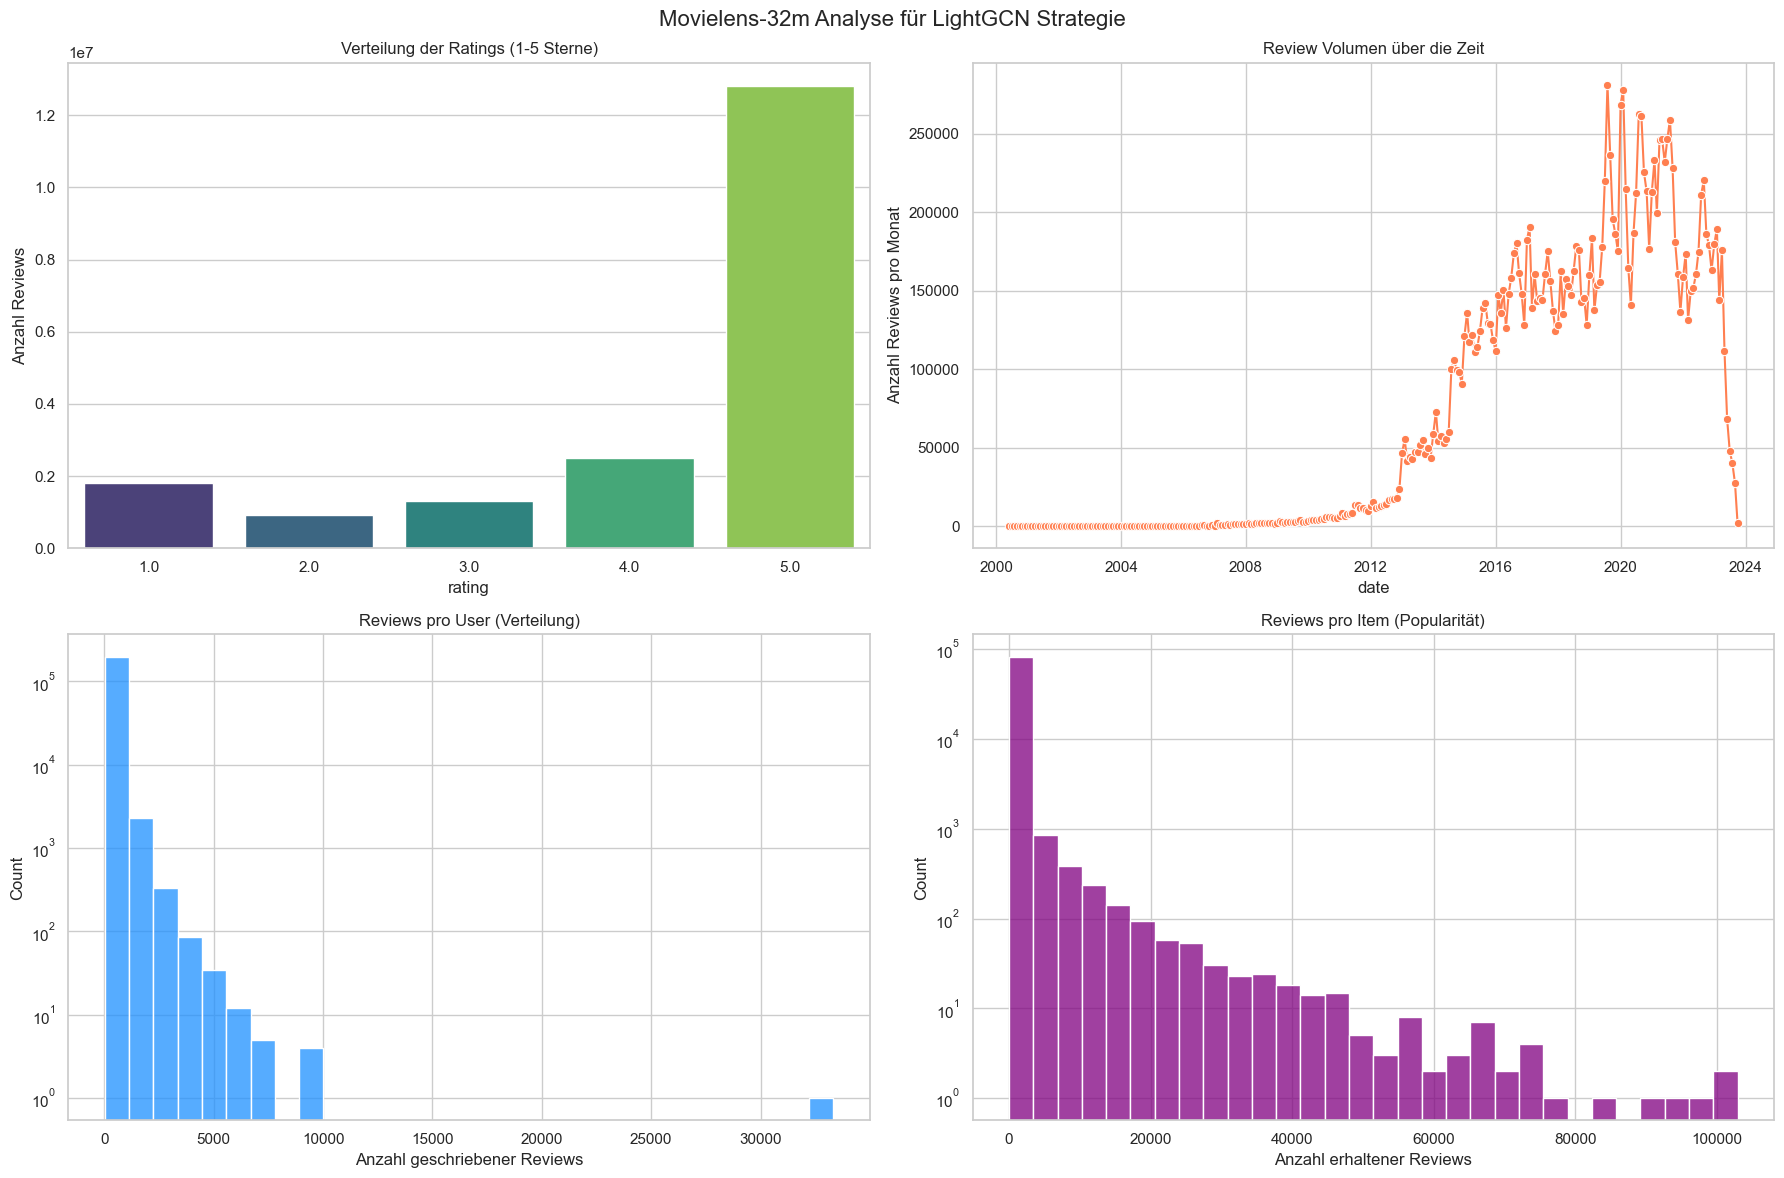

In [57]:
# Setzen des Styles für schönere Plots
sns.set_theme(style="whitegrid")

# Erstellen einer Figure mit Subplots für Übersichtlichkeit
fig, axes = plt.subplots(2, 2, figsize=(18, 12))
fig.suptitle('Movielens-32m Analyse für LightGCN Strategie', fontsize=16)
# ---------------------------------------------------------
# PLOT A: Rating Verteilung
# Wichtig für: Müssen wir negative Samples filtern?
# ---------------------------------------------------------
sns.countplot(ax=axes[0, 0], x='rating', data=df, palette='viridis')
axes[0, 0].set_title('Verteilung der Ratings (1-5 Sterne)')
axes[0, 0].set_ylabel('Anzahl Reviews')

# ---------------------------------------------------------
# PLOT B: Zeitliche Verteilung (Review Volume over Time)
# Wichtig für: Entscheidung zwischen Random vs. Temporal Split
# ---------------------------------------------------------
# Wir gruppieren nach Datum, um das Volumen pro Zeit zu sehen
time_data = df.groupby('date').size().reset_index(name='counts')
# Resampling auf Monate für glattere Kurven (bei großen Datenmengen wichtig)
time_data = time_data.set_index('date').resample('M').sum().reset_index()

sns.lineplot(ax=axes[0, 1], x='date', y='counts', data=time_data, marker='o', color='coral')
axes[0, 1].set_title('Review Volumen über die Zeit')
axes[0, 1].set_ylabel('Anzahl Reviews pro Monat')

# ---------------------------------------------------------
# PLOT C: User Interaktionen (Sparsity Check)
# Wichtig für: Filtern von inaktiven Usern (k-core filtering)
# ---------------------------------------------------------
# Da wir hier nur Dummy-Daten haben, simulieren wir für die Erklärung:
user_counts = df_movie['userId'].value_counts()

# Histogramm der User-Interaktionen (log scale ist hier oft nötig bei echten Daten)
sns.histplot(ax=axes[1, 0], x=user_counts, bins=30, kde=False, color='dodgerblue')
axes[1, 0].set_title('Reviews pro User (Verteilung)')
axes[1, 0].set_xlabel('Anzahl geschriebener Reviews')
axes[1, 0].set_yscale('log') # Log-Skala, da Amazon Daten "Long Tail" sind

# ---------------------------------------------------------
# PLOT D: Item Popularität
# Wichtig für: Wie stark bias das Modell zu populären Items tendieren wird
# ---------------------------------------------------------
item_counts = df_movie['movieId'].value_counts()

sns.histplot(ax=axes[1, 1], x=item_counts, bins=30, kde=False, color='purple')
axes[1, 1].set_title('Reviews pro Item (Popularität)')
axes[1, 1].set_xlabel('Anzahl erhaltener Reviews')
axes[1, 1].set_yscale('log')

plt.tight_layout()
plt.show()

In [ ]:
print()

In [8]:
df_train = pd.read_csv(PROCESSED_DATA_PATH / "movielens-32m_global_temporal_split/train.csv",
                       names=['userId', 'movieId', 'rating', 'timestamp'])
#df_val = pd.read_csv(PROCESSED_DATA_PATH / "sports_and_outdoors_global_temporal_split/valid.csv", names=['user_id', 'parent_asin', 'rating', 'timestamp'])
df_test = pd.read_csv(PROCESSED_DATA_PATH / "movielens-32m_global_temporal_split/test.csv",
                      names=['userId', 'movieId', 'rating', 'timestamp'])



In [9]:
print("Train users:", df_train['userId'].nunique())
#print("Val users:", df_val['user_id'].nunique())
print("Test users:", df_test['userId'].nunique())
print("Total interactions:", len(df_train) + len(df_test))
print("Train interactions:", len(df_train))
#print("Val interactions:", len(df_val))
print("Test interactions:", len(df_test))
print("Train percentage:", len(df_train) / (len(df_train) + len(df_test)))
#print("Val percentage:", len(df_val) / (len(df_train) + len(df_val) + len(df_test)))
print("Test percentage:", len(df_test) / (len(df_train) + len(df_test)))

Train users: 187947
Test users: 7896
Total interactions: 29648345
Train interactions: 29052900
Test interactions: 595445
Train percentage: 0.9799164169197303
Test percentage: 0.02008358308026974


In [12]:
df_train['date'] = pd.to_datetime(df_train['timestamp'], unit='s')
print(f"Trainingsdaten von " , df_train['date'].min(), "bis", df_train['date'].max())
#df_val['date'] = pd.to_datetime(df_val['timestamp'], unit='ms')
#print(f"Validierungsdaten von " , df_val['date'].min(), "bis", df_val['date'].max())
df_test['date'] = pd.to_datetime(df_test['timestamp'], unit='s')
print(f"Testdaten von " , df_test['date'].min(), "bis", df_test['date'].max())

Trainingsdaten von  1995-01-09 11:46:44 bis 2020-12-31 22:59:09
Testdaten von  2020-12-31 23:00:40 bis 2023-10-13 02:29:07
